In [108]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
import re
import json
from datetime import date, datetime, timedelta
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker

In [109]:
# file naming variables
today = date.today()
last_version = today - timedelta(days=7)
location = '/Users/Sim/Documents/Other/Programming/Personal Projects/Property Price Monitor'

In [110]:
# Load last week's data
df = pd.read_csv(f'{location}/data/df_{last_version}.csv')
df = df.drop('Unnamed: 0', axis=1)

In [111]:
df2 = pd.DataFrame(
    {"Date": [],
     "Average Price": [],
     "Median Price": [],
     "10th Percentile": [],
     "90th Percentile": [],
     "Std dev": [],
     "Sample Size": []
    })

In [112]:
# First import the scraping functions
from ipynb.fs.full.Monitor_funcs import scrape_results_page

### Scraper

*The scraper Loops through rightmove results pages of 5 London areas extracting link, price and featured property status of each property*


**What areas?**

5 relevant, non-overlapping areas defined by a 1 mile (or 0.5 mile) radius around the following tube stations (also see screenshot below):
- Kentish Town (1 mile)
- Royal Oak (1 mile)
- Finchley Road (1 mile)
- Angel (1 mile)
- Mornington Crescent (0.5 miles)


**What search criteria are used?**

I specify that properties must:
- have exactly 2 bedrooms and be a house/flat/apartment to ensure we compare like with like
- have been posted in last 7 days to ensure they don't appear in last week's scrape


**Why are there two scrapers?**

The first scraper loops through the 4 stations with 1mile radii. Due to the much lower number of properties in 0.5 miles around Mornington Crescent, results rarely go onto a second page meaning. Therefore I simply created a specific scraping code for it.

![alt text](Areas.png "Areas")

In [113]:
links = scrape_results_page()[1]
date_time = scrape_results_page()[2]
prices = scrape_results_page()[3]
featured = scrape_results_page()[4]

In [114]:
date_time = pd.to_datetime(date_time,dayfirst = True, format = "%d/%m/%Y %H:%M")
dates = date_time.date

In [115]:
# convert to dataframe
data = {"Links": links,
        "DateTimeScraped": date_time,
        "DateScraped": dates,
        "Price": prices,
        "Featured": featured,
       }
df3 = pd.DataFrame.from_dict(data)

In [120]:
len(df3)

114

In [119]:
# Remove featured properties
df3 = df3[df3.Featured != 1]

# Sampling 120 rows
df3=df3.sample(n = min(120,len(df3)))

In [124]:
# Key scrape info
date = datetime.strptime(str(df3.loc[2,'DateScraped']), "%Y-%m-%d").strftime("%d/%m/%Y")
avg_price, n = round(np.mean(df3['Price']),2), len(df3)
median_price, ten  = round(np.median(df3['Price']),2), round(np.percentile(df3['Price'], 10),2)
ninety, st_dev = round(np.percentile(df3['Price'], 90),2), round(np.std(df3['Price']),3)

# Key info df
df2.loc[len(df2)] = [date, avg_price,median_price, ten,ninety, st_dev,n]
df2

,Date,Average Price,Median Price,10th Percentile,90th Percentile,Std dev,Sample Size
0,06/11/2022,867789.56,850000.0,524000.0,1250000.0,303834.617,120
1,13/11/2022,952266.24,875000.0,497500.0,1477500.0,448923.051,120
2,20/11/2022,871647.03,812500.0,500000.0,1254500.0,327990.409,120
0,27/11/2022,898337.72,850000.0,532500.0,1335000.0,324512.391,114
4,27/11/2022,898337.72,850000.0,532500.0,1335000.0,324512.391,114


In [131]:
#df2 = df2.reset_index(drop=True)
#df2=df2.drop([4])
#df2

,Date,Average Price,Median Price,10th Percentile,90th Percentile,Std dev,Sample Size
0,06/11/2022,867789.56,850000.0,524000.0,1250000.0,303834.617,120
1,13/11/2022,952266.24,875000.0,497500.0,1477500.0,448923.051,120
2,20/11/2022,871647.03,812500.0,500000.0,1254500.0,327990.409,120
3,27/11/2022,898337.72,850000.0,532500.0,1335000.0,324512.391,114


In [132]:
df2 = pd.concat([df, df2]).reset_index(drop=True)
df2

,Date,Average Price,Median Price,10th Percentile,90th Percentile,Std dev,Sample Size
0,06/11/2022,867789.56,850000.0,524000.0,1250000.0,303834.617,120
1,13/11/2022,952266.24,875000.0,497500.0,1477500.0,448923.051,120
2,20/11/2022,871647.03,812500.0,500000.0,1254500.0,327990.409,120
3,27/11/2022,898337.72,850000.0,532500.0,1335000.0,324512.391,114


In [133]:
# Save to csv
df3.to_csv(f'{location}/data/full_df_{today}.csv') 
df2.to_csv(f'{location}/data/df_{today}.csv')

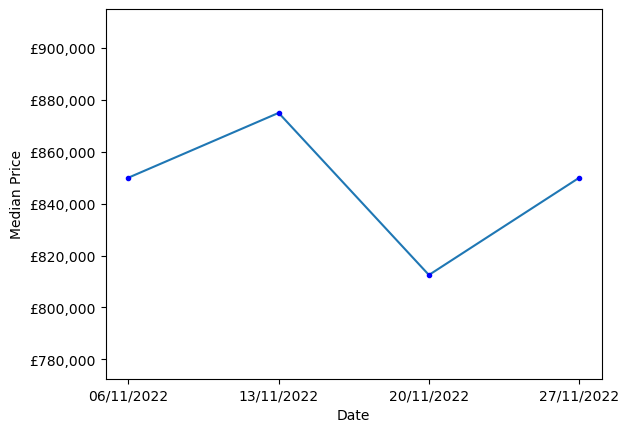

In [134]:
# Plotting
fig, ax = plt.subplots()
ax.plot(df2['Date'],df2['Median Price'])

# Use automatic StrMethodFormatter
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '£{:,}'.format(int(x), ',')))
ax.yaxis.set_tick_params(which='major', labelcolor='black',labelleft=True)
ax.plot(df2['Date'],df2['Median Price'], ".", color = 'b')

plt.ylabel('Median Price')
plt.xlabel('Date')
plt.ylim([min(df2['Median Price'])-40000, max(df2['Median Price'])+40000])

#plt.savefig(f'{location}/charts/{today}_medians.png')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(df2['Date'],df2['Average Price'])

# Use automatic StrMethodFormatter
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '£{:,}'.format(int(x), ',')))
ax.yaxis.set_tick_params(which='major', labelcolor='black',labelleft=True)
ax.plot(df2['Date'],df2['Average Price'], ".", color = 'b')

plt.ylabel('Median Price')
plt.xlabel('Date')
plt.ylim([min(df2['Average Price'])-40000, max(df2['Average Price'])+40000])

plt.show()